In [2]:
from __future__ import print_function
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from keras.layers import Conv2DTranspose, LeakyReLU
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import initializers
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import cv2
import math

from keras.datasets import mnist

import os

from keras.utils.vis_utils import plot_model
from keras.utils.generic_utils import Progbar

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [20]:
#pip install pydot-ng

Note: you may need to restart the kernel to use updated packages.


In [21]:
#pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [22]:
#pip install pydot==1.2.3

  Created wheel for pydot: filename=pydot-1.2.3-py3-none-any.whl size=18931 sha256=719dfeeb0c2cb3db3d6c064767749262f60649e615641978958540bf6e407f81
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\94\a8\4b\d76c975fd000ecff606a1b170d541bbef0f6429fe1084dcb49
Successfully built pydot
Note: you may need to restart the kernel to use updated packages.


In [3]:
def load_mnist_data():
    """ load mnist data """
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_test = (X_test.astype(np.float32) - 127.5) / 127.5

    X_train = X_train[:,:,:,None]
    X_test = X_test[:,:,:,None]

    X_test_original = X_test.copy()

    #X_train = X_train[Y_train==0]
    #X_test = X_test[Y_test==0]
    print('train shape: ', X_train.shape)

    return X_train, X_test, X_test_original, Y_test 

In [4]:
""" build generator model """
def generator_model(z_dim, imgsize, channels): 
    col = int(imgsize / 4)
    inputs = Input((z_dim, ))
    fc1 = Dense(input_dim=z_dim, units=128*col*col)(inputs)
    fc1 = BatchNormalization()(fc1)
    fc1 = LeakyReLU(0.2)(fc1)

    fc2 = Reshape((col, col, 128), input_shape=(128*col*col,))(fc1)
    up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(fc2)
    conv1 = Conv2D(64, (3,3), padding='same')(up1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)

    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1)
    conv2 = Conv2D(channels, (5, 5), padding='same')(up2)
    outputs = Activation('tanh')(conv2)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [5]:
""" build discriminator model """
def discriminator_model(img_size, channels):
    inputs = Input((img_size, img_size, channels))

    conv1 = Conv2D(64, (5,5), padding='same')(inputs)
    conv1 = LeakyReLU(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(128, (5,5), padding='same')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    fc1 = Flatten()(pool2)
    fc1 = Dense(1)(fc1)
    outputs = Activation('sigmoid')(fc1)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [6]:
def generator_containg_discriminator(g, d, z_dim):
    d.trainable = False

    ganInput = Input(shape=(z_dim, ))
    x = g(ganInput)
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)

    return gan

In [7]:
class DCGAN():
    def __init__(self, imgsize,channels,zdims,epoch,batchsize):

        self.img_size = imgsize
        self.channels = channels
        self.z_dim = zdims
        self.epochs = epoch
        self.batch_size = batchsize

        self.d_opt = Adam(lr=1e-5, beta_1=0.1)
        self.g_opt = Adam(lr=2e-4, beta_1=0.5)

        if not os.path.exists('./result/'):
            os.makedirs('./result/')
        if not os.path.exists('./model_images/'):
            os.makedirs('./model_images/')

        """ build discriminator model """
        self.d = discriminator_model(self.img_size, self.channels)
        plot_model(self.d, to_file='./model_images/discriminator.png', show_shapes=True)

        """ build generator model """
        self.g = generator_model(self.z_dim, self.img_size, self.channels)
        plot_model(self.g, to_file='./model_images/generator.png', show_shapes=True)

        """ discriminator on generator model """
        self.d_on_g = generator_containg_discriminator(self.g, self.d, self.z_dim)
        plot_model(self.d_on_g, to_file='./model_images/d_on_g.png', show_shapes=True)

        self.g.compile(loss='mse', optimizer=self.g_opt)
        self.d_on_g.compile(loss='mse', optimizer=self.g_opt)
        self.d.trainable = True
        self.d.compile(loss='mse', optimizer=self.d_opt)

    """ plot images for visualization """
    def plot_generate_images(self, gen_images):
        num = gen_images.shape[0]
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
        shape = gen_images.shape[1:4]
        image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                            dtype=gen_images.dtype)
        for index, img in enumerate(gen_images):
            i = int(index/width)
            j = index % width
            image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1], :] = img[:, :, :]
        return image

    """ generate image """
    def generate(self, batch_size):
        self.g.load_weights('./saved_model/generator.h5')
        noise = np.random.uniform(0, 1, (batch_size, self.z_dim))
        generate_img = self.g.predict(noise)

        return generate_img

    def train(self, X_train):
        for epoch in range(self.epochs):
            print ("Epoch is ", epoch)
            n_iter = int(X_train.shape[0] / self.batch_size)
            progress_bar = Progbar(target=n_iter)

            for index in range(n_iter):
                # create random noise -> U(0,1) 10 vactors
                noise = np.random.uniform(0, 1, size=(self.batch_size, self.z_dim))

                """ load real data & generate fake data """
                image_batch = X_train[index*self.batch_size:(index+1)*self.batch_size]
                gen_images = self.g.predict(noise, verbose=0)

                # visualize training result
                if index % 50 == 0:
                    image = self.plot_generate_images(gen_images)
                    image =  image*127.5+127.5
                    cv2.imwrite('./result/' + str(epoch)+"_"+str(index)+ ".png", image )

                # attach label for training discriminator
                X = np.concatenate((image_batch, gen_images))
                y = np.array([1] * self.batch_size + [0] * self.batch_size)

                """ training discriminator """
                d_loss = self.d.train_on_batch(X, y)

                """ training generator """
                self.d.trainable = False
                g_loss = self.d_on_g.train_on_batch(noise, np.array([1] * self.batch_size))
                self.d.trainable = True

                progress_bar.update(index, values=[('g', g_loss), ('d', d_loss)])
            print('')

            """ save weights for each epoch """
            if not os.path.exists('./saved_model/'):
                os.makedirs('./saved_model/')
            self.g.save_weights('./saved_model/generator.h5', True)
            self.d.save_weights('./saved_model/discriminator.h5',True)

        return self.d, self.g

initialize DCGAN 
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7,

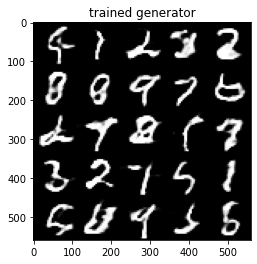

In [8]:
print("initialize DCGAN ")
imgsize = 28
channels = 1
zdims = 100
epoch = 10
batchsize = 64
dcgan = DCGAN(imgsize,channels,zdims,epoch,batchsize)

X_train, X_test, X_test_original, Y_test = load_mnist_data()

print ('============ train on DCGAN ============')
dcgan.train(X_train)

""" test generator """
gen_img = dcgan.generate(25)
img = dcgan.plot_generate_images(gen_img)
img = (img*127.5)+127.5
img = img.astype(np.uint8)
img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)

""" plt view """
plt.figure(num=0, figsize=(4, 4))
plt.title('trained generator')
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [25]:
ruined = X_train[:1000].copy()
normal = X_train[1000:2000].copy()

In [30]:
ruined[:,3,5:15] = 1
ruined[:,1:10,5:10] = 1

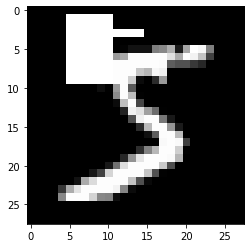

In [31]:
plt.imshow(ruined[0].reshape((28,28)), cmap='gray')

In [33]:
predicted_normal = dcgan.d.predict(normal)
predicted_ruined = dcgan.d.predict(ruined)

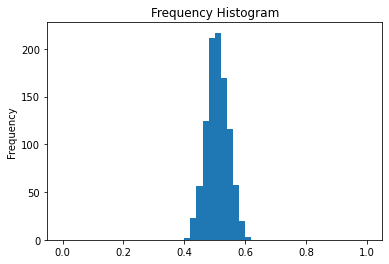

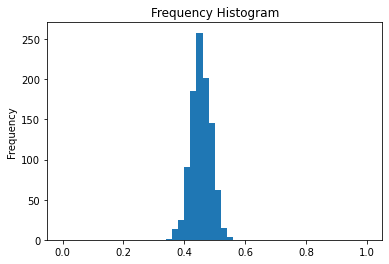

In [29]:
import matplotlib.pyplot as plt

plt.hist(predicted_normal, bins=50, range=(0,1))
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
plt.show()

plt.hist(predicted_ruined, bins=50, range=(0,1))
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');


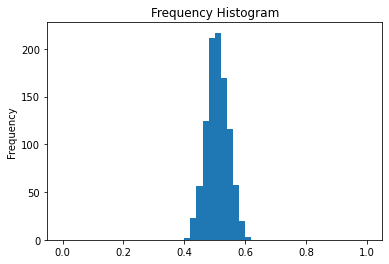

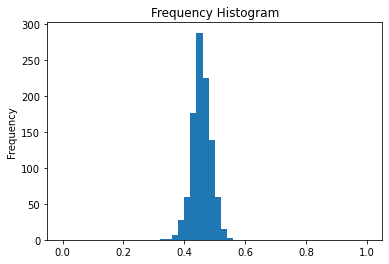

In [34]:
import matplotlib.pyplot as plt

plt.hist(predicted_normal, bins=50, range=(0,1))
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
plt.show()

plt.hist(predicted_ruined, bins=50, range=(0,1))
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');


In [35]:
print(predicted_normal[:10])

[[0.5499465 ]
 [0.5768991 ]
 [0.47738972]
 [0.608556  ]
 [0.46044612]
 [0.5836755 ]
 [0.50669247]
 [0.50132823]
 [0.5773849 ]
 [0.5532083 ]]
